In [1]:
#Source paper
#https://arxiv.org/pdf/1703.03872

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

################################################################################
# 1) VGG-16 Encoder (blocks 1..4) with 4-channel input
#    We collect 3 skip outputs (from the ends of blocks 1,2,3),
#    then do block4 + "fc6-as-conv" as the bottom (1/16 scale).
################################################################################
class VGG16Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Load VGG16 with new "weights" param (instead of pretrained=True)
        vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        features = vgg16.features  # nn.Sequential of conv/pool layers

        # 1) Modify the first Conv2d to take 4 channels (RGB+Trimap)
        old_conv0 = features[0]  # conv2d(3,64, kernel_size=3, padding=1)
        new_conv0 = nn.Conv2d(4, 64, kernel_size=3, padding=1)
        with torch.no_grad():
            # Copy weights for RGB, set the 4th channel to zero
            new_conv0.weight[:, :3] = old_conv0.weight
            new_conv0.weight[:, 3]  = 0.0
            new_conv0.bias[:]       = old_conv0.bias
        features[0] = new_conv0
        
        # 2) Split the standard VGG16 feature extractor into four blocks:
        #
        #    block1: [0..4]   = conv1_1, relu, conv1_2, relu, pool => 1/2 scale
        #    block2: [5..9]   = conv2_1, relu, conv2_2, relu, pool => 1/4 scale
        #    block3: [10..16] = conv3_1, relu, conv3_2, relu, conv3_3, relu, pool => 1/8 scale
        #    block4: [17..23] = conv4_1, relu, conv4_2, relu, conv4_3, relu, pool => 1/16 scale
        #
        #    (We won't use block5 for this UNet-style matting.)
        #
        self.block1 = features[0:5]    # conv1_x + pool => output 1/2
        self.block2 = features[5:10]   # conv2_x + pool => output 1/4
        self.block3 = features[10:17]  # conv3_x + pool => output 1/8
        self.block4 = features[17:24]  # conv4_x + pool => output 1/16

        # 3) Turn "fc6" into a 1×1 or 3×3 conv.  In official VGG, fc6 is 4096 units.
        #    We can reduce it here to keep memory smaller. E.g. out_channels=512.
        #    We'll use kernel_size=3, stride=1, padding=1 so shape stays 1/16.
        self.fc6_conv = nn.Conv2d(in_channels=512, out_channels=512,
                                  kernel_size=3, padding=1)
        # Initialize fc6 from the old VGG fc6 if you like. We do a fresh Xavier init:
        nn.init.xavier_normal_(self.fc6_conv.weight)

    def forward(self, x):
        """
        x: [B,4,H,W]  (RGB + Trimap)
        Returns:
          bottom:  [B,512, H/16, W/16] after block4 + fc6
          skips: [skip1, skip2, skip3]
                  skip1 => [B,64,  H/2,  W/2]
                  skip2 => [B,128, H/4,  W/4]
                  skip3 => [B,256, H/8,  W/8]
        """
        # Block1 => 1/2 scale
        x = self.block1(x)
        skip1 = x  # shape ~ [B,64, H/2, W/2]

        # Block2 => 1/4 scale
        x = self.block2(x)
        skip2 = x  # shape ~ [B,128, H/4, W/4]

        # Block3 => 1/8 scale
        x = self.block3(x)
        skip3 = x  # shape ~ [B,256, H/8, W/8]

        # Block4 => 1/16 scale
        x = self.block4(x)  # shape ~ [B,512, H/16, W/16]

        # fc6-as-conv => keep 1/16 scale
        x = self.fc6_conv(x)  # [B,512, H/16, W/16]
        x = F.relu(x, inplace=True)

        return x, [skip1, skip2, skip3]

################################################################################
# 2) UNet-Style Decoder: from 1/16 -> 1/8 -> 1/4 -> 1/2 -> 1
################################################################################
class DecoderBlock(nn.Module):
    """
    A simple "cat->conv->conv->relu" block, for after we upsample.
    """
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class MattingDecoder(nn.Module):
    """
    Decode from bottom feature (1/16 scale) back to full res 1× size.
    We'll do 3 "decoder steps" merging skip3, skip2, skip1, then
    a final upsample to 1× and 1×1 conv => alpha.
    """
    def __init__(self):
        super().__init__()
        # After block4+fc6, we have [B,512,H/16,W/16].
        # skip3 => [B,256,H/8,W/8]
        # skip2 => [B,128,H/4,W/4]
        # skip1 => [B, 64,H/2,W/2]

        # Step 1: Upsample from 1/16 => 1/8, cat skip3 => out => [B,256?]
        self.dec3 = DecoderBlock(in_ch=512+256, out_ch=256)
        # Step 2: Upsample from 1/8 => 1/4, cat skip2 => out => [B,128?]
        self.dec2 = DecoderBlock(in_ch=256+128, out_ch=128)
        # Step 3: Upsample from 1/4 => 1/2, cat skip1 => out => [B,64?]
        self.dec1 = DecoderBlock(in_ch=128+64, out_ch=64)

        # Finally upsample 1/2 => 1, then do 1×1 conv => 1 channel alpha
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, bottom, skips):
        """
        bottom: [B,512,H/16,W/16]
        skips: [skip1, skip2, skip3]
        """
        skip1, skip2, skip3 = skips

        # 1) upsample bottom 1/16 -> 1/8
        x = F.interpolate(bottom, scale_factor=2, mode='bilinear', align_corners=True)
        # cat skip3 (which is 1/8 scale)
        x = torch.cat([x, skip3], dim=1)  # => [B,512+256, H/8, W/8]
        x = self.dec3(x)  # => [B,256, H/8, W/8]

        # 2) upsample 1/8 -> 1/4
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip2], dim=1)  # => [B,256+128, H/4, W/4]
        x = self.dec2(x)  # => [B,128, H/4, W/4]

        # 3) upsample 1/4 -> 1/2
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip1], dim=1)  # => [B,128+64, H/2, W/2]
        x = self.dec1(x)  # => [B,64, H/2, W/2]

        # 4) final upsample 1/2 -> 1
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)  
        # => [B,64,H,W]

        alpha = self.final_conv(x)  # => [B,1,H,W]
        return alpha

################################################################################
# 3) Stage-1 Matting Network:  (VGG16 Encoder -> UNet Decoder)
################################################################################
class Stage1MattingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = VGG16Encoder()
        self.decoder = MattingDecoder()

    def forward(self, x):
        """
        x: [B,4,H,W] => raw_alpha [B,1,H,W]
        """
        bottom, skips = self.encoder(x)
        alpha = self.decoder(bottom, skips)
        return alpha

################################################################################
# 4) Refinement Network: (raw_alpha + original RGB) -> refined_alpha
################################################################################
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(channels)
        self.relu  = nn.ReLU(inplace=True)
    def forward(self, x):
        skip = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x = x + skip
        x = self.relu(x)
        return x

class RefinementNet(nn.Module):
    """
    Takes [B,4,H,W] = (3-channel RGB + 1-channel raw alpha),
    outputs refined alpha of shape [B,1,H,W].
    """
    def __init__(self, in_ch=4, mid_ch=64):
        super().__init__()
        self.head = nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1)
        self.bn_head = nn.BatchNorm2d(mid_ch)
        self.res1 = ResidualBlock(mid_ch)
        self.res2 = ResidualBlock(mid_ch)
        self.res3 = ResidualBlock(mid_ch)
        self.final_conv = nn.Conv2d(mid_ch, 1, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.bn_head(self.head(x)))
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        out_alpha = self.final_conv(x)
        return out_alpha

################################################################################
# 5) Two-Stage Model (Stage1 + Stage2)
################################################################################
class TwoStageMattingNet(nn.Module):
    """
    - Stage1: UNet (VGG16) => raw_alpha
    - Stage2: refine => refined_alpha
    """
    def __init__(self):
        super().__init__()
        self.stage1 = Stage1MattingNet()
        self.stage2 = RefinementNet()

    def forward(self, rgb, trimap):
        """
        rgb:    [B,3,H,W]
        trimap: [B,1,H,W]
        Returns (raw_alpha, refined_alpha)
        """
        # 1) Stage1
        x_stage1 = torch.cat([rgb, trimap], dim=1)  # => [B,4,H,W]
        raw_alpha = self.stage1(x_stage1)           # => [B,1,H,W]

        # 2) Stage2
        x_stage2 = torch.cat([rgb, raw_alpha], dim=1)  # => [B,4,H,W]
        refined_alpha = self.stage2(x_stage2)           # => [B,1,H,W]

        return raw_alpha, refined_alpha

################################################################################
# 6) Demo / Test
################################################################################
# if __name__ == "__main__":
#     B, H, W = 1, 512, 512
#     rgb    = torch.randn(B, 3, H, W)
#     trimap = torch.randn(B, 1, H, W)

#     model = TwoStageMattingNet()
#     with torch.no_grad():
#         raw_alpha, refined_alpha = model(rgb, trimap)

#     print("rgb:           ", rgb.shape)
#     print("trimap:        ", trimap.shape)
#     print("raw_alpha:     ", raw_alpha.shape)
#     print("refined_alpha: ", refined_alpha.shape)


In [20]:
import os
import cv2
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F  # For PyTorch functional operations like relu
import torchvision.transforms.functional as TF  # For transformations like vflip, hflip

import matplotlib.pyplot as plt



# Set directories
DATASET_PATH = "/kaggle/input/alpha-matte-dataset/"
GT_DIR = os.path.join(DATASET_PATH, "gt_training_lowres")
INPUT_DIR = os.path.join(DATASET_PATH, "input_training_lowres")
TRIMAP_DIR = os.path.join(DATASET_PATH, "trimap_training_lowres/Trimap1")

# Fixed image size
IMG_SIZE = (512, 512)

################################################################################
# 1) Custom Dataset
################################################################################
class AlphaMatteDataset(Dataset):
    def __init__(self, input_dir, trimap_dir, gt_dir, transform=None):
        self.input_dir = input_dir
        self.trimap_dir = trimap_dir
        self.gt_dir = gt_dir
        self.input_files = sorted(os.listdir(input_dir))  # Sort to match trimap/gt
        self.transform = transform

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        # Load input, trimap, and ground truth
        input_path = os.path.join(self.input_dir, self.input_files[idx])
        trimap_path = os.path.join(self.trimap_dir, self.input_files[idx])
        gt_path = os.path.join(self.gt_dir, self.input_files[idx])
        
        input_image = cv2.imread(input_path, cv2.IMREAD_COLOR)  # RGB image
        trimap = cv2.imread(trimap_path, cv2.IMREAD_GRAYSCALE)  # Single channel
        gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)          # Ground truth alpha

        # Convert to RGB and normalize
        input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
        
        # Resize all to fixed size
        input_image = cv2.resize(input_image, IMG_SIZE)
        trimap = cv2.resize(trimap, IMG_SIZE)
        gt = cv2.resize(gt, IMG_SIZE)

        # Convert to tensor
        input_image = transforms.ToTensor()(input_image)
        trimap = transforms.ToTensor()(trimap)
        gt = transforms.ToTensor()(gt)

        # Apply transforms
        if self.transform:
            input_image, trimap, gt = self.transform(input_image, trimap, gt)

        return input_image, trimap, gt

################################################################################
# 2) Transformations (Augmentations)
################################################################################
def random_transform(input_image, trimap, gt):
    # Random horizontal flip
    if random.random() > 0.5:
        input_image = TF.hflip(input_image)
        trimap = TF.hflip(trimap)
        gt = TF.hflip(gt)

    # Random vertical flip
    if random.random() > 0.5:
        input_image = TF.vflip(input_image)
        trimap = TF.vflip(trimap)
        gt = TF.vflip(gt)

    # Color jitter on input image
    color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    input_image = color_jitter(input_image)

    return input_image, trimap, gt


################################################################################
# 3) Loss Functions
################################################################################
def alpha_prediction_loss(pred_alpha, gt_alpha):
    return torch.mean((pred_alpha - gt_alpha) ** 2)

def compositional_loss(pred_alpha, gt_alpha, fg, bg, input_image):
    pred_composite = pred_alpha * fg + (1 - pred_alpha) * bg
    gt_composite = gt_alpha * fg + (1 - gt_alpha) * bg
    return torch.mean((pred_composite - gt_composite) ** 2)

################################################################################
# 4) Training Setup
################################################################################
# Dataset and DataLoader
dataset = AlphaMatteDataset(
    INPUT_DIR,
    TRIMAP_DIR,
    GT_DIR,
    transform=random_transform
)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

# Model, optimizer, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TwoStageMattingNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in data_loader:
        input_image, trimap, gt_alpha = batch
        input_image = input_image.to(device)
        trimap = trimap.to(device)
        gt_alpha = gt_alpha.to(device)

        # Forward pass
        raw_alpha, refined_alpha = model(input_image, trimap)

        # Losses
        pred_loss = alpha_prediction_loss(refined_alpha, gt_alpha)
        # Dummy foreground/background for compositional loss
        fg = torch.ones_like(gt_alpha)  # Replace with actual FG
        bg = torch.zeros_like(gt_alpha)  # Replace with actual BG
        comp_loss = compositional_loss(refined_alpha, gt_alpha, fg, bg, input_image)

        loss = pred_loss + comp_loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Scheduler step
    scheduler.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(data_loader):.4f}")

################################################################################
# 5) Save the Model
################################################################################
torch.save(model.state_dict(), "matting_model.pth")
print("Model saved!")


Epoch 1/100, Loss: 4.0790
Epoch 2/100, Loss: 1.3517
Epoch 3/100, Loss: 0.5535
Epoch 4/100, Loss: 0.2668
Epoch 5/100, Loss: 0.2020
Epoch 6/100, Loss: 0.1856
Epoch 7/100, Loss: 0.1604
Epoch 8/100, Loss: 0.1249
Epoch 9/100, Loss: 0.1189
Epoch 10/100, Loss: 0.1089
Epoch 11/100, Loss: 0.1025
Epoch 12/100, Loss: 0.0805
Epoch 13/100, Loss: 0.0891
Epoch 14/100, Loss: 0.0860
Epoch 15/100, Loss: 0.0954
Epoch 16/100, Loss: 0.0924
Epoch 17/100, Loss: 0.0881
Epoch 18/100, Loss: 0.0665
Epoch 19/100, Loss: 0.0673
Epoch 20/100, Loss: 0.0615
Epoch 21/100, Loss: 0.0653
Epoch 22/100, Loss: 0.0674
Epoch 23/100, Loss: 0.0605
Epoch 24/100, Loss: 0.0784
Epoch 25/100, Loss: 0.0554
Epoch 26/100, Loss: 0.0625
Epoch 27/100, Loss: 0.0626
Epoch 28/100, Loss: 0.0649
Epoch 29/100, Loss: 0.0562
Epoch 30/100, Loss: 0.0521
Epoch 31/100, Loss: 0.0502
Epoch 32/100, Loss: 0.0586
Epoch 33/100, Loss: 0.0572
Epoch 34/100, Loss: 0.0464
Epoch 35/100, Loss: 0.0520
Epoch 36/100, Loss: 0.0453
Epoch 37/100, Loss: 0.0458
Epoch 38/1

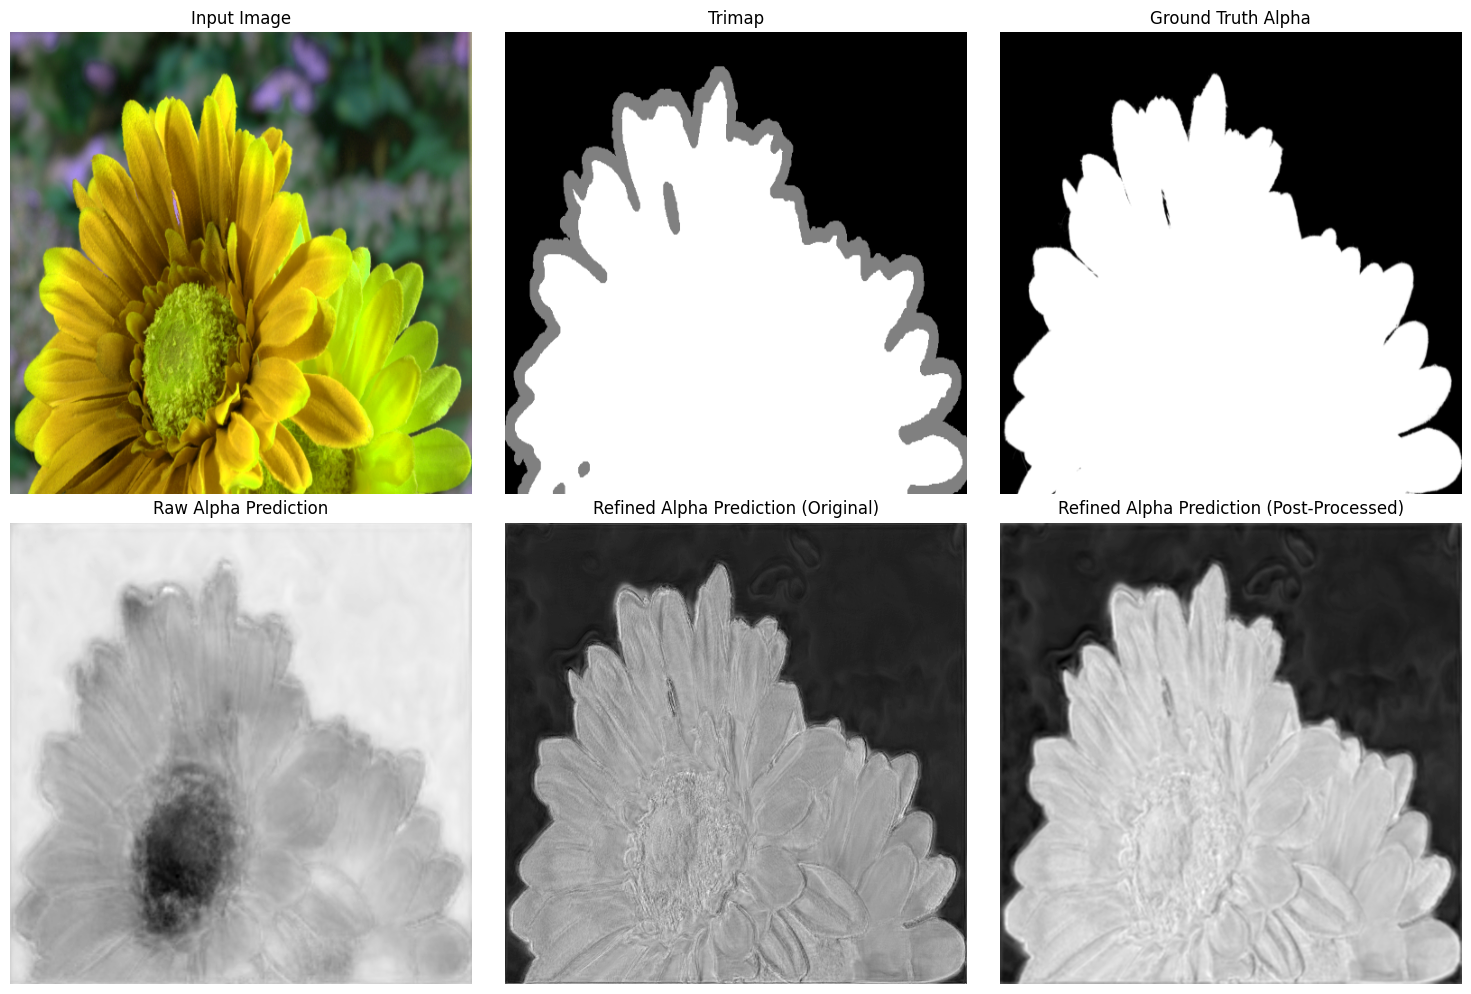

In [13]:
def post_process_alpha(alpha):
    """
    Post-process the refined alpha prediction to enhance contrast
    without over-simplifying the matte.
    """
    # Normalize the alpha matte to the range [0, 1]
    alpha = (alpha - alpha.min()) / (alpha.max() - alpha.min())

    # Stretch the contrast using a power-law transformation (gamma correction)
    gamma = 0.7  # Lower values enhance transparency regions
    alpha = np.power(alpha, gamma)

    # Optional: Apply a small Gaussian blur to smooth edges
    alpha = cv2.GaussianBlur(alpha, (5, 5), 0)

    # Clip to ensure values are in [0, 1]
    alpha = np.clip(alpha, 0.0, 1.0)

    return alpha


def visualize_results_with_postprocessing(model, dataset, device):
    """
    Test the trained model on a random datapoint and visualize the results with post-processing.
    """
    # Set model to evaluation mode
    model.eval()

    # Pick a random datapoint
    idx = random.randint(0, len(dataset) - 1)
    input_image, trimap, gt_alpha = dataset[idx]
    
    # Unsqueeze to create a batch of 1
    input_image = input_image.unsqueeze(0).to(device)
    trimap = trimap.unsqueeze(0).to(device)
    gt_alpha = gt_alpha.unsqueeze(0).to(device)

    # Forward pass through the model
    with torch.no_grad():
        raw_alpha, refined_alpha = model(input_image, trimap)

    # Convert tensors to numpy arrays for visualization
    input_image = input_image.cpu().squeeze(0).permute(1, 2, 0).numpy()
    trimap = trimap.cpu().squeeze(0).squeeze(0).numpy()
    gt_alpha = gt_alpha.cpu().squeeze(0).squeeze(0).numpy()
    raw_alpha = raw_alpha.cpu().squeeze(0).squeeze(0).numpy()
    refined_alpha = refined_alpha.cpu().squeeze(0).squeeze(0).numpy()

    # Post-process refined alpha
    refined_alpha_post = post_process_alpha(refined_alpha)

    # Plot results
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    plt.imshow(input_image)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(2, 3, 2)
    plt.imshow(trimap, cmap="gray")
    plt.title("Trimap")
    plt.axis("off")

    plt.subplot(2, 3, 3)
    plt.imshow(gt_alpha, cmap="gray")
    plt.title("Ground Truth Alpha")
    plt.axis("off")

    plt.subplot(2, 3, 4)
    plt.imshow(raw_alpha, cmap="gray")
    plt.title("Raw Alpha Prediction")
    plt.axis("off")

    plt.subplot(2, 3, 5)
    plt.imshow(refined_alpha, cmap="gray")
    plt.title("Refined Alpha Prediction (Original)")
    plt.axis("off")

    plt.subplot(2, 3, 6)
    plt.imshow(refined_alpha_post, cmap="gray")
    plt.title("Refined Alpha Prediction (Post-Processed)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# Visualize with post-processing
visualize_results_with_postprocessing(model, dataset, device)


In [ ]:
##try new loss function

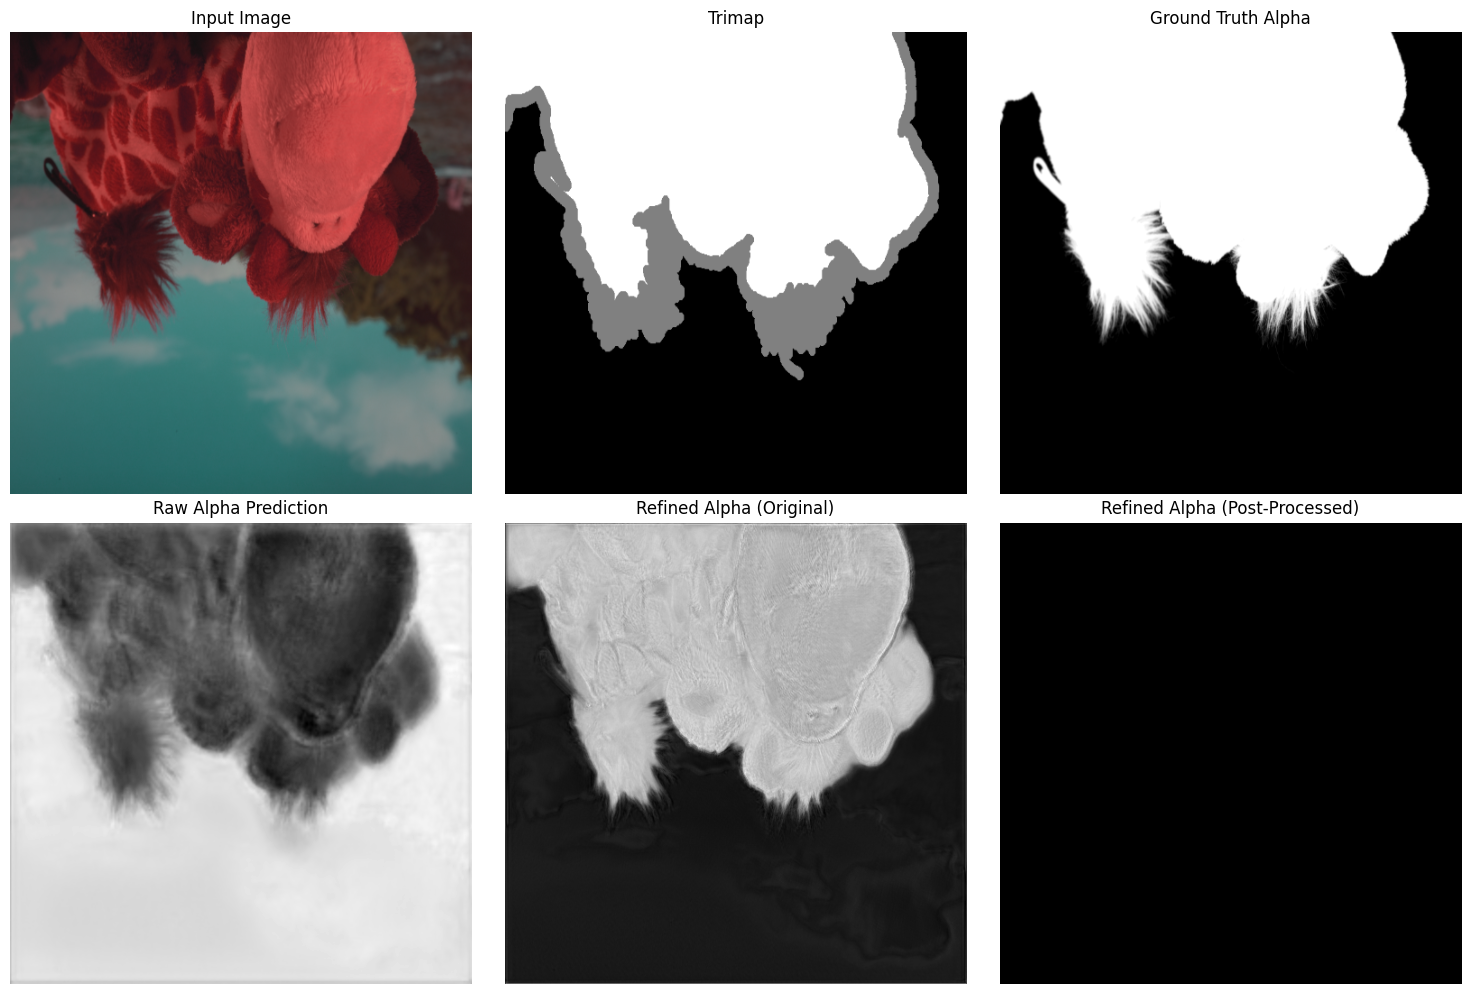

In [17]:
import numpy as np
import cv2

def post_process_alpha_with_trimap(refined_alpha, trimap):
    """
    Refine alpha by combining with the trimap:
      - Force alpha=0 in background region of trimap
      - Force alpha=1 in foreground region of trimap
      - Use the network's refined alpha only in unknown region
    Also apply optional morphological or smoothing operations on the unknown region.
    
    Args:
        refined_alpha (np.ndarray): The network's refined alpha, in [0,1].
        trimap (np.ndarray): The trimap array with values in {0, 128, 255}
                             indicating background, unknown, foreground.
    Returns:
        np.ndarray: The final alpha after post-processing.
    """
    # 1. Normalize refined_alpha to [0, 1] just to be safe.
    #    (Assuming it's already close to [0, 1], but in case it’s out of range.)
    if refined_alpha.min() < 0 or refined_alpha.max() > 1:
        refined_alpha = (refined_alpha - refined_alpha.min()) / (refined_alpha.max() - refined_alpha.min() + 1e-7)
    
    # 2. Separate out the known background/foreground from the unknown.
    #    We will clamp alpha=0 and alpha=1 in known regions.
    known_bg_mask = (trimap == 0).astype(np.float32)
    known_fg_mask = (trimap == 255).astype(np.float32)
    unknown_mask  = (trimap == 128).astype(np.float32)
    
    # 3. Optionally, you can apply morphological operations on the unknown region
    #    to shrink or expand it slightly if you want to “clean up” edges.
    #    For example, a small erosion or dilation:
    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    # unknown_mask = cv2.erode(unknown_mask, kernel, iterations=1)
    
    # 4. Combine the trimap with refined alpha:
    #    - alpha=1 wherever trimap=foreground
    #    - alpha=0 wherever trimap=background
    #    - alpha=refined_alpha wherever trimap=unknown
    final_alpha = (known_fg_mask * 1.0) + (unknown_mask * refined_alpha)
    # known_bg_mask is implicitly alpha=0.
    
    # 5. Optional: Apply a small blur in the unknown region only, to smooth edges
    #    without blurring the fully known areas.
    #    a) Blur the whole final_alpha
    blurred = cv2.GaussianBlur(final_alpha, (3, 3), 0)
    #    b) Only replace the unknown pixels with their blurred values
    final_alpha = (1 - unknown_mask) * final_alpha + unknown_mask * blurred
    
    # 6. (Optional) Apply a gamma correction if you want to lighten/darken the transition:
    gamma = 0.7
    final_alpha = np.power(np.clip(final_alpha, 0, 1), gamma)
    
    # 7. Clip to [0, 1] in case any numeric drift occurred.
    final_alpha = np.clip(final_alpha, 0.0, 1.0)

    return final_alpha
def visualize_results_with_postprocessing(model, dataset, device):
    """
    Test the trained model on a random datapoint and visualize the results with post-processing.
    """
    model.eval()

    idx = random.randint(0, len(dataset) - 1)
    input_image, trimap, gt_alpha = dataset[idx]

    input_image = input_image.unsqueeze(0).to(device)
    trimap = trimap.unsqueeze(0).to(device)
    gt_alpha = gt_alpha.unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        raw_alpha, refined_alpha = model(input_image, trimap)

    # Convert tensors to numpy
    input_image_np = input_image.cpu().squeeze(0).permute(1, 2, 0).numpy()
    trimap_np      = trimap.cpu().squeeze(0).squeeze(0).numpy()
    gt_alpha_np    = gt_alpha.cpu().squeeze(0).squeeze(0).numpy()
    raw_alpha_np   = raw_alpha.cpu().squeeze(0).squeeze(0).numpy()
    refined_alpha_np = refined_alpha.cpu().squeeze(0).squeeze(0).numpy()

    # Post-process refined alpha with trimap
    refined_alpha_post = post_process_alpha_with_trimap(refined_alpha_np, trimap_np)

    # Visualize
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    plt.imshow(input_image_np)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(2, 3, 2)
    plt.imshow(trimap_np, cmap="gray")
    plt.title("Trimap")
    plt.axis("off")

    plt.subplot(2, 3, 3)
    plt.imshow(gt_alpha_np, cmap="gray")
    plt.title("Ground Truth Alpha")
    plt.axis("off")

    plt.subplot(2, 3, 4)
    plt.imshow(raw_alpha_np, cmap="gray")
    plt.title("Raw Alpha Prediction")
    plt.axis("off")

    plt.subplot(2, 3, 5)
    plt.imshow(refined_alpha_np, cmap="gray")
    plt.title("Refined Alpha (Original)")
    plt.axis("off")

    plt.subplot(2, 3, 6)
    plt.imshow(refined_alpha_post, cmap="gray")
    plt.title("Refined Alpha (Post-Processed)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
visualize_results_with_postprocessing(model, dataset, device)

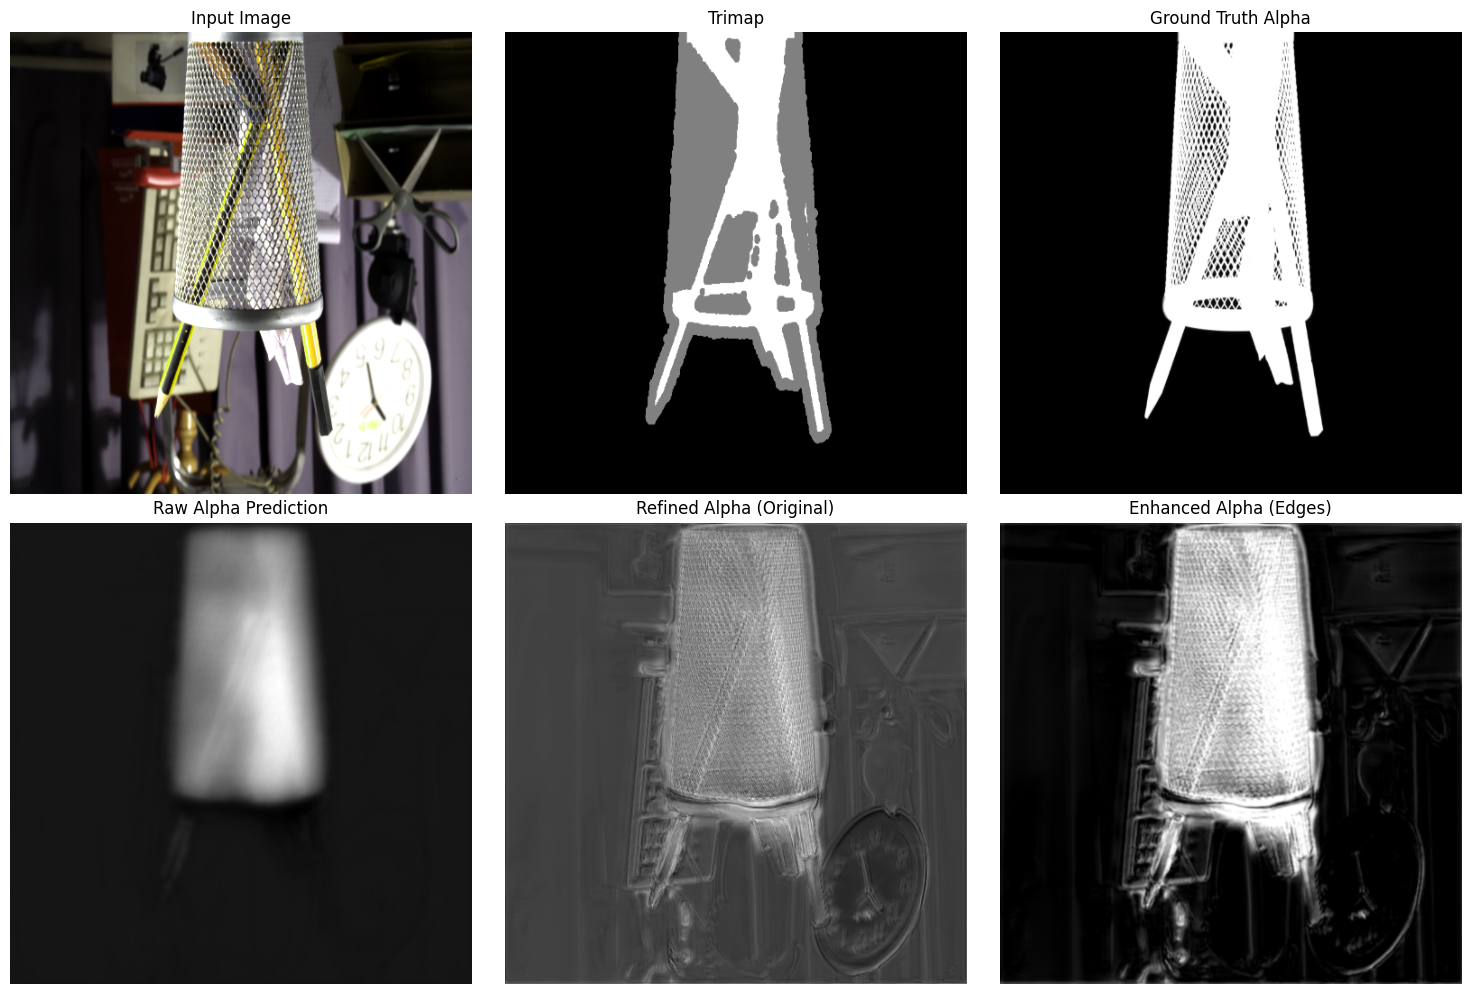

In [19]:
import random
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt


def advanced_edge_processing(refined_alpha, trimap):
    """
    Advanced edge-only processing for alpha matte refinement.

    Args:
        refined_alpha (np.ndarray): Refined alpha matte in [0, 1].
        trimap (np.ndarray): Trimap array with values in {0, 128, 255}.

    Returns:
        np.ndarray: Alpha matte with enhanced edge refinement.
    """
    # Normalize alpha to [0, 1]
    refined_alpha = np.clip(refined_alpha, 0, 1)

    # Detect edges in the refined alpha matte
    edges = cv2.Canny((refined_alpha * 255).astype(np.uint8), 50, 150)

    # Dilate the edges to expand the edge region
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    edges_dilated = cv2.dilate(edges, kernel, iterations=1)

    # Mask for the edge region
    edge_mask = (edges_dilated > 0).astype(np.float32)

    # Unknown region from trimap
    unknown_mask = (trimap == 128).astype(np.float32)

    # Combine edge mask with unknown region
    edge_unknown_mask = edge_mask * unknown_mask

    # Smooth the refined alpha for the edge region
    smoothed_alpha = cv2.GaussianBlur(refined_alpha, (5, 5), 0)

    # Blend the smoothed alpha into the edge regions
    enhanced_alpha = refined_alpha.copy()
    enhanced_alpha[edge_unknown_mask > 0] = smoothed_alpha[edge_unknown_mask > 0]

    # Optional: Apply additional smoothing to the entire alpha matte
    final_alpha = cv2.GaussianBlur(enhanced_alpha, (3, 3), 0)

    return final_alpha


def visualize_results_with_advanced_processing(model, dataset, device):
    """
    Test the trained model on a random datapoint and visualize the results with advanced edge processing.
    """
    model.eval()

    idx = random.randint(0, len(dataset) - 1)
    input_image, trimap, gt_alpha = dataset[idx]

    input_image = input_image.unsqueeze(0).to(device)
    trimap = trimap.unsqueeze(0).to(device)
    gt_alpha = gt_alpha.unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        raw_alpha, refined_alpha = model(input_image, trimap)

    # Convert tensors to numpy
    input_image_np = input_image.cpu().squeeze(0).permute(1, 2, 0).numpy()
    trimap_np = trimap.cpu().squeeze(0).squeeze(0).numpy()
    gt_alpha_np = gt_alpha.cpu().squeeze(0).squeeze(0).numpy()
    raw_alpha_np = raw_alpha.cpu().squeeze(0).squeeze(0).numpy()
    refined_alpha_np = refined_alpha.cpu().squeeze(0).squeeze(0).numpy()

    # Process edges of the alpha matte
    processed_alpha = advanced_edge_processing(refined_alpha_np, trimap_np)

    # Visualize
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    plt.imshow(input_image_np)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(2, 3, 2)
    plt.imshow(trimap_np, cmap="gray")
    plt.title("Trimap")
    plt.axis("off")

    plt.subplot(2, 3, 3)
    plt.imshow(gt_alpha_np, cmap="gray")
    plt.title("Ground Truth Alpha")
    plt.axis("off")

    plt.subplot(2, 3, 4)
    plt.imshow(raw_alpha_np, cmap="gray")
    plt.title("Raw Alpha Prediction")
    plt.axis("off")

    plt.subplot(2, 3, 5)
    plt.imshow(refined_alpha_np, cmap="gray")
    plt.title("Refined Alpha (Original)")
    plt.axis("off")

    plt.subplot(2, 3, 6)
    plt.imshow(processed_alpha, cmap="gray")
    plt.title("Enhanced Alpha (Edges)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# Example usage
# Replace `model`, `dataset`, and `device` with your actual model, dataset, and device.
visualize_results_with_advanced_processing(model, dataset, device)


Epoch 1/100, Loss: 0.9208
Best model saved at epoch 1 with loss 0.9208
Epoch 2/100, Loss: 0.5107
Best model saved at epoch 2 with loss 0.5107
Epoch 3/100, Loss: 0.3671
Best model saved at epoch 3 with loss 0.3671
Epoch 4/100, Loss: 0.3419
Best model saved at epoch 4 with loss 0.3419
Epoch 5/100, Loss: 0.2699
Best model saved at epoch 5 with loss 0.2699
Epoch 6/100, Loss: 0.2499
Best model saved at epoch 6 with loss 0.2499
Epoch 7/100, Loss: 0.2493
Best model saved at epoch 7 with loss 0.2493
Epoch 8/100, Loss: 0.2363
Best model saved at epoch 8 with loss 0.2363
Epoch 9/100, Loss: 0.2197
Best model saved at epoch 9 with loss 0.2197
Epoch 10/100, Loss: 0.2148
Best model saved at epoch 10 with loss 0.2148
Epoch 11/100, Loss: 0.2094
Best model saved at epoch 11 with loss 0.2094
Epoch 12/100, Loss: 0.2058
Best model saved at epoch 12 with loss 0.2058
Epoch 13/100, Loss: 0.1997
Best model saved at epoch 13 with loss 0.1997
Epoch 14/100, Loss: 0.1872
Best model saved at epoch 14 with loss 0.1

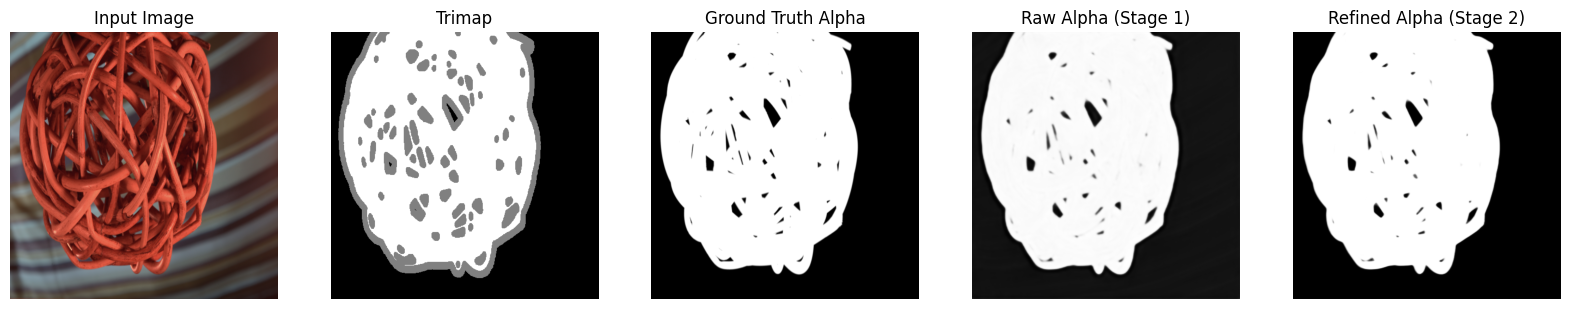

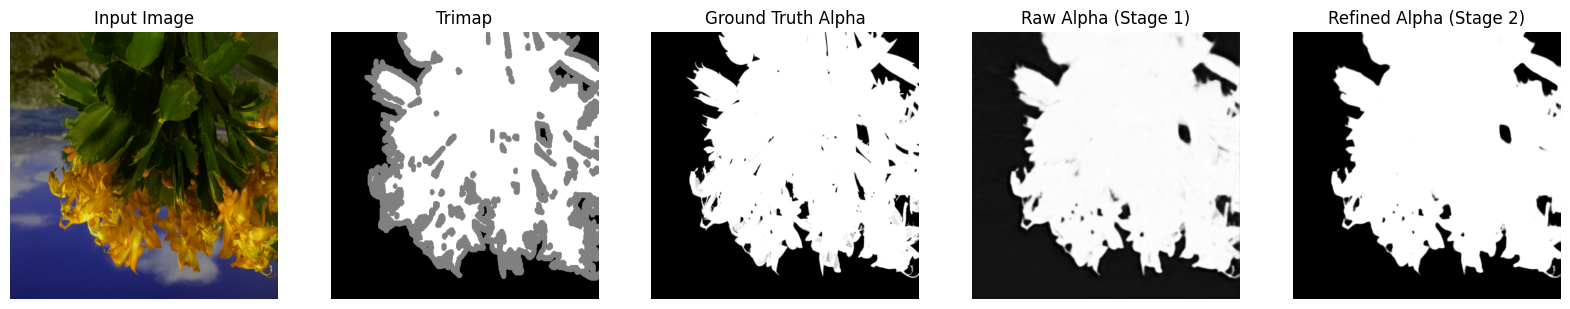

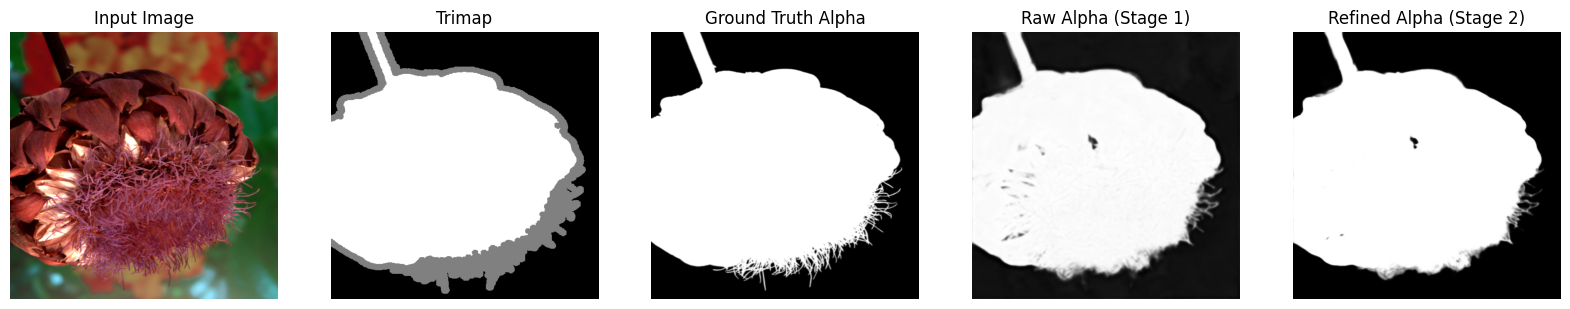

In [21]:
import os
import cv2
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F  # For PyTorch functional operations like relu
import torchvision.transforms.functional as TF  # For transformations like vflip, hflip
import matplotlib.pyplot as plt

################################################################################
# Model Definitions
################################################################################

import torch.nn as nn

class VGG16Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Load VGG16 with pretrained weights
        vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        features = vgg16.features  # nn.Sequential of conv/pool layers

        # Modify the first Conv2d to take 4 channels (RGB + Trimap)
        old_conv0 = features[0]  # conv2d(3,64, kernel_size=3, padding=1)
        new_conv0 = nn.Conv2d(4, 64, kernel_size=3, padding=1)
        with torch.no_grad():
            new_conv0.weight[:, :3] = old_conv0.weight
            new_conv0.weight[:, 3] = 0.0  # Initialize the 4th channel to zero
            new_conv0.bias[:] = old_conv0.bias
        features[0] = new_conv0

        # Split VGG16 into four blocks
        self.block1 = features[0:5]    # conv1_x + pool => output 1/2
        self.block2 = features[5:10]   # conv2_x + pool => output 1/4
        self.block3 = features[10:17]  # conv3_x + pool => output 1/8
        self.block4 = features[17:24]  # conv4_x + pool => output 1/16

        # fc6-as-conv
        self.fc6_conv = nn.Conv2d(in_channels=512, out_channels=512,
                                  kernel_size=3, padding=1)
        nn.init.xavier_normal_(self.fc6_conv.weight)

    def forward(self, x):
        """
        x: [B,4,H,W]  (RGB + Trimap)
        Returns:
          bottom:  [B,512, H/16, W/16] after block4 + fc6
          skips: [skip1, skip2, skip3]
                  skip1 => [B,64,  H/2,  W/2]
                  skip2 => [B,128, H/4,  W/4]
                  skip3 => [B,256, H/8,  W/8]
        """
        # Block1 => 1/2 scale
        x = self.block1(x)
        skip1 = x  # [B,64, H/2, W/2]

        # Block2 => 1/4 scale
        x = self.block2(x)
        skip2 = x  # [B,128, H/4, W/4]

        # Block3 => 1/8 scale
        x = self.block3(x)
        skip3 = x  # [B,256, H/8, W/8]

        # Block4 => 1/16 scale
        x = self.block4(x)  # [B,512, H/16, W/16]

        # fc6-as-conv => keep 1/16 scale
        x = self.fc6_conv(x)  # [B,512, H/16, W/16]
        x = F.relu(x, inplace=True)

        return x, [skip1, skip2, skip3]

class DecoderBlock(nn.Module):
    """
    A simple "cat->conv->conv->relu" block, for after we upsample.
    """
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class MattingDecoder(nn.Module):
    """
    Decode from bottom feature (1/16 scale) back to full res 1× size.
    """
    def __init__(self):
        super().__init__()
        # After block4+fc6, we have [B,512,H/16,W/16].
        # skip3 => [B,256,H/8,W/8]
        # skip2 => [B,128,H/4,W/4]
        # skip1 => [B, 64,H/2,W/2]

        # Decoder blocks
        self.dec3 = DecoderBlock(in_ch=512+256, out_ch=256)
        self.dec2 = DecoderBlock(in_ch=256+128, out_ch=128)
        self.dec1 = DecoderBlock(in_ch=128+64, out_ch=64)

        # Final upsample and alpha prediction
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, bottom, skips):
        """
        bottom: [B,512,H/16,W/16]
        skips: [skip1, skip2, skip3]
        """
        skip1, skip2, skip3 = skips

        # Step 1: 1/16 -> 1/8
        x = F.interpolate(bottom, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip3], dim=1)  # [B,768, H/8, W/8]
        x = self.dec3(x)  # [B,256, H/8, W/8]

        # Step 2: 1/8 -> 1/4
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip2], dim=1)  # [B,384, H/4, W/4]
        x = self.dec2(x)  # [B,128, H/4, W/4]

        # Step 3: 1/4 -> 1/2
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip1], dim=1)  # [B,192, H/2, W/2]
        x = self.dec1(x)  # [B,64, H/2, W/2]

        # Final upsample to original size
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)  # [B,64,H,W]
        alpha = self.final_conv(x)  # [B,1,H,W]
        alpha = torch.sigmoid(alpha)  # Ensure output is between 0 and 1
        return alpha

class Stage1MattingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = VGG16Encoder()
        self.decoder = MattingDecoder()

    def forward(self, x):
        """
        x: [B,4,H,W] => raw_alpha [B,1,H,W]
        """
        bottom, skips = self.encoder(x)
        alpha = self.decoder(bottom, skips)
        return alpha

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(channels)
        self.relu  = nn.ReLU(inplace=True)

    def forward(self, x):
        skip = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x = x + skip
        x = self.relu(x)
        return x

class RefinementNet(nn.Module):
    """
    Takes [B,4,H,W] = (3-channel RGB + 1-channel raw alpha),
    outputs refined alpha of shape [B,1,H,W].
    """
    def __init__(self, in_ch=4, mid_ch=64):
        super().__init__()
        self.head = nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1)
        self.bn_head = nn.BatchNorm2d(mid_ch)
        self.res1 = ResidualBlock(mid_ch)
        self.res2 = ResidualBlock(mid_ch)
        self.res3 = ResidualBlock(mid_ch)
        self.final_conv = nn.Conv2d(mid_ch, 1, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.bn_head(self.head(x)))
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        out_alpha = self.final_conv(x)
        out_alpha = torch.sigmoid(out_alpha)  # Ensure output is between 0 and 1
        return out_alpha

class TwoStageMattingNet(nn.Module):
    """
    - Stage1: UNet (VGG16) => raw_alpha
    - Stage2: refine => refined_alpha
    """
    def __init__(self):
        super().__init__()
        self.stage1 = Stage1MattingNet()
        self.stage2 = RefinementNet()

    def forward(self, rgb, trimap):
        """
        rgb:    [B,3,H,W]
        trimap: [B,1,H,W]
        Returns (raw_alpha, refined_alpha)
        """
        # Stage 1
        x_stage1 = torch.cat([rgb, trimap], dim=1)  # [B,4,H,W]
        raw_alpha = self.stage1(x_stage1)           # [B,1,H,W]

        # Stage 2
        x_stage2 = torch.cat([rgb, raw_alpha], dim=1)  # [B,4,H,W]
        refined_alpha = self.stage2(x_stage2)           # [B,1,H,W]

        return raw_alpha, refined_alpha

################################################################################
# Dataset and DataLoader
################################################################################

# Set directories
DATASET_PATH = "/kaggle/input/alpha-matte-dataset/"
GT_DIR = os.path.join(DATASET_PATH, "gt_training_lowres")
INPUT_DIR = os.path.join(DATASET_PATH, "input_training_lowres")
TRIMAP_DIR = os.path.join(DATASET_PATH, "trimap_training_lowres/Trimap1")

# Fixed image size
IMG_SIZE = (512, 512)

class AlphaMatteDataset(Dataset):
    def __init__(self, input_dir, trimap_dir, gt_dir, transform=None):
        self.input_dir = input_dir
        self.trimap_dir = trimap_dir
        self.gt_dir = gt_dir
        self.input_files = sorted(os.listdir(input_dir))  # Ensure matching order
        self.transform = transform

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        # Load input, trimap, and ground truth
        input_path = os.path.join(self.input_dir, self.input_files[idx])
        trimap_path = os.path.join(self.trimap_dir, self.input_files[idx])
        gt_path = os.path.join(self.gt_dir, self.input_files[idx])

        # Read images
        input_image = cv2.imread(input_path, cv2.IMREAD_COLOR)  # BGR
        trimap = cv2.imread(trimap_path, cv2.IMREAD_GRAYSCALE)  # Single channel
        gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)          # Ground truth alpha

        # Convert BGR to RGB
        input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

        # Resize to fixed size
        input_image = cv2.resize(input_image, IMG_SIZE, interpolation=cv2.INTER_AREA)
        trimap = cv2.resize(trimap, IMG_SIZE, interpolation=cv2.INTER_NEAREST)
        gt = cv2.resize(gt, IMG_SIZE, interpolation=cv2.INTER_AREA)

        # Normalize trimap to [0,1]
        trimap = trimap / 255.0
        gt = gt / 255.0

        # Convert to tensor
        input_image = transforms.ToTensor()(input_image)  # [3, H, W], [0,1]
        trimap = torch.from_numpy(trimap).unsqueeze(0).float()  # [1, H, W], [0,1]
        gt = torch.from_numpy(gt).unsqueeze(0).float()          # [1, H, W], [0,1]

        # Apply transforms
        if self.transform:
            input_image, trimap, gt = self.transform(input_image, trimap, gt)

        return input_image, trimap, gt

################################################################################
# Transformations (Augmentations)
################################################################################

def random_transform(input_image, trimap, gt):
    # Random horizontal flip
    if random.random() > 0.5:
        input_image = TF.hflip(input_image)
        trimap = TF.hflip(trimap)
        gt = TF.hflip(gt)

    # Random vertical flip
    if random.random() > 0.5:
        input_image = TF.vflip(input_image)
        trimap = TF.vflip(trimap)
        gt = TF.vflip(gt)

    # Random rotation
    angle = random.choice([0, 90, 180, 270])
    if angle != 0:
        input_image = TF.rotate(input_image, angle)
        trimap = TF.rotate(trimap, angle)
        gt = TF.rotate(gt, angle)

    # Color jitter on input image
    color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    input_image = color_jitter(input_image)

    return input_image, trimap, gt

################################################################################
# Loss Functions
################################################################################

def alpha_prediction_loss(pred_alpha, gt_alpha, trimap):
    """
    Combines L1 Loss and Gradient Difference Loss (GDL).
    Applies higher weights to uncertain regions based on the trimap.
    """
    # Define trimap regions
    # Assuming trimap has values:
    # 0 -> background
    # 1 -> foreground
    # 0.5 -> unknown
    unknown_mask = (trimap > 0.4) & (trimap < 0.6)  # Adjust thresholds as needed

    # Create weight map
    weight = torch.ones_like(gt_alpha)
    weight[unknown_mask] = 2.0  # Higher weight for unknown regions

    # L1 Loss
    l1_loss = F.l1_loss(pred_alpha, gt_alpha, reduction='none')
    l1_loss = l1_loss * weight
    l1_loss = l1_loss.mean()

    # Gradient Difference Loss (GDL)
    def gradient(x):
        dx = x[:, :, :-1, :] - x[:, :, 1:, :]
        dy = x[:, :, :, :-1] - x[:, :, :, 1:]
        return dx, dy

    pred_dx, pred_dy = gradient(pred_alpha)
    gt_dx, gt_dy = gradient(gt_alpha)

    gdl_loss = F.l1_loss(pred_dx, gt_dx, reduction='mean') + F.l1_loss(pred_dy, gt_dy, reduction='mean')

    # Combine losses with weights
    total_loss = l1_loss + 0.5 * gdl_loss  # Adjust weights as needed
    return total_loss

def compositional_loss(pred_alpha, gt_alpha, input_image, trimap):
    """
    Computes the compositional loss using accurate foreground and background extraction.
    """
    # Ensure alpha is in [0,1]
    pred_alpha = torch.clamp(pred_alpha, 0.0, 1.0)
    gt_alpha = torch.clamp(gt_alpha, 0.0, 1.0)

    # Extract foreground and background based on ground truth alpha
    fg = input_image  # Assuming foreground is the input image where alpha=1
    bg = input_image  # Assuming background is the input image where alpha=0

    # Alternatively, if separate fg and bg images are available, use them
    # fg = ... 
    # bg = ...

    # Composite the image using predicted and ground truth alpha
    pred_composite = pred_alpha * fg + (1 - pred_alpha) * bg
    gt_composite = gt_alpha * fg + (1 - gt_alpha) * bg

    # Compute L2 loss between composited images
    comp_loss = F.mse_loss(pred_composite, gt_composite)

    return comp_loss

def smoothness_loss(alpha):
    """
    Encourages spatial smoothness in the alpha matte.
    """
    dx = alpha[:, :, :-1, :] - alpha[:, :, 1:, :]
    dy = alpha[:, :, :, :-1] - alpha[:, :, :, 1:]
    loss = torch.mean(torch.abs(dx)) + torch.mean(torch.abs(dy))
    return loss

def total_loss_function(raw_alpha, refined_alpha, gt_alpha, input_image, trimap):
    """
    Combines all loss components.
    """
    # Stage 1 Loss (raw_alpha)
    loss_stage1 = alpha_prediction_loss(raw_alpha, gt_alpha, trimap)

    # Stage 2 Loss (refined_alpha)
    loss_stage2 = alpha_prediction_loss(refined_alpha, gt_alpha, trimap)

    # Compositional Loss using refined_alpha
    comp_loss = compositional_loss(refined_alpha, gt_alpha, input_image, trimap)

    # Smoothness Loss on refined_alpha
    smooth_loss = smoothness_loss(refined_alpha)

    # Total Loss with appropriate weighting
    total_loss = loss_stage1 + loss_stage2 + comp_loss + 0.1 * smooth_loss  # Adjust weights as needed
    return total_loss

################################################################################
# Training Setup
################################################################################

# Dataset and DataLoader
dataset = AlphaMatteDataset(
    INPUT_DIR,
    TRIMAP_DIR,
    GT_DIR,
    transform=random_transform
)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

# Initialize model, optimizer, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TwoStageMattingNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

################################################################################
# Training Loop
################################################################################

num_epochs = 100
best_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, batch in enumerate(data_loader):
        input_image, trimap, gt_alpha = batch
        input_image = input_image.to(device)
        trimap = trimap.to(device)
        gt_alpha = gt_alpha.to(device)

        # Forward pass
        raw_alpha, refined_alpha = model(input_image, trimap)

        # Compute total loss
        loss = total_loss_function(raw_alpha, refined_alpha, gt_alpha, input_image, trimap)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Scheduler step
    scheduler.step()

    average_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}")

    # Save the model if it's the best so far
    if average_loss < best_loss:
        best_loss = average_loss
        torch.save(model.state_dict(), "matting_model_best.pth")
        print(f"Best model saved at epoch {epoch + 1} with loss {best_loss:.4f}")

################################################################################
# Save the Final Model
################################################################################

torch.save(model.state_dict(), "matting_model_final.pth")
print("Final model saved as 'matting_model_final.pth'!")

################################################################################
# (Optional) Visualization
################################################################################

def visualize_results(model, dataloader, device, num_samples=5):
    model.eval()
    samples = 0
    with torch.no_grad():
        for batch in dataloader:
            input_image, trimap, gt_alpha = batch
            input_image = input_image.to(device)
            trimap = trimap.to(device)
            gt_alpha = gt_alpha.to(device)

            raw_alpha, refined_alpha = model(input_image, trimap)

            # Move tensors to CPU and convert to numpy
            input_image_np = input_image.cpu().numpy()
            trimap_np = trimap.cpu().numpy()
            gt_alpha_np = gt_alpha.cpu().numpy()
            raw_alpha_np = raw_alpha.cpu().numpy()
            refined_alpha_np = refined_alpha.cpu().numpy()

            batch_size = input_image_np.shape[0]
            for i in range(batch_size):
                fig, axs = plt.subplots(1, 5, figsize=(20, 4))
                axs[0].imshow(np.transpose(input_image_np[i], (1, 2, 0)))
                axs[0].set_title("Input Image")
                axs[0].axis('off')

                axs[1].imshow(trimap_np[i][0], cmap='gray')
                axs[1].set_title("Trimap")
                axs[1].axis('off')

                axs[2].imshow(gt_alpha_np[i][0], cmap='gray')
                axs[2].set_title("Ground Truth Alpha")
                axs[2].axis('off')

                axs[3].imshow(raw_alpha_np[i][0], cmap='gray')
                axs[3].set_title("Raw Alpha (Stage 1)")
                axs[3].axis('off')

                axs[4].imshow(refined_alpha_np[i][0], cmap='gray')
                axs[4].set_title("Refined Alpha (Stage 2)")
                axs[4].axis('off')

                plt.show()

                samples += 1
                if samples >= num_samples:
                    return

# Example usage after training:
visualize_results(model, data_loader, device, num_samples=3)


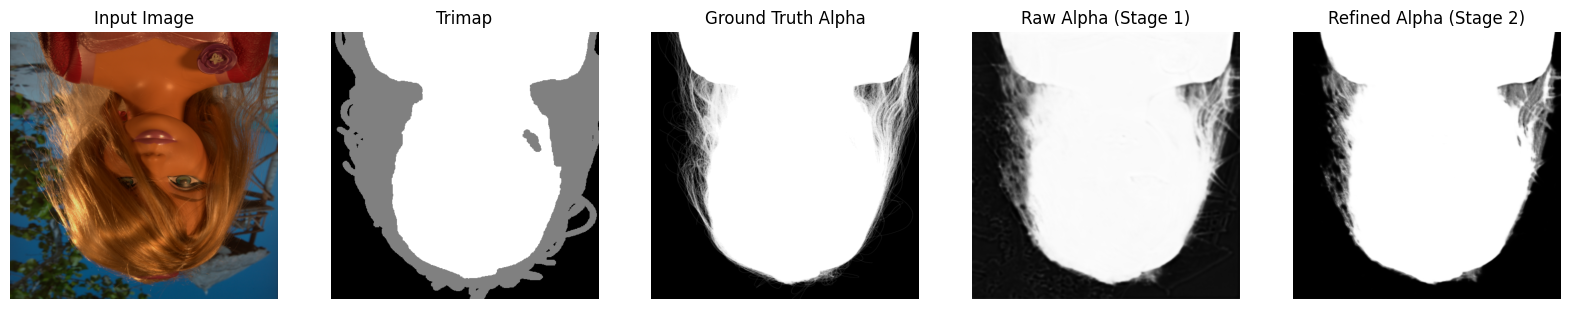

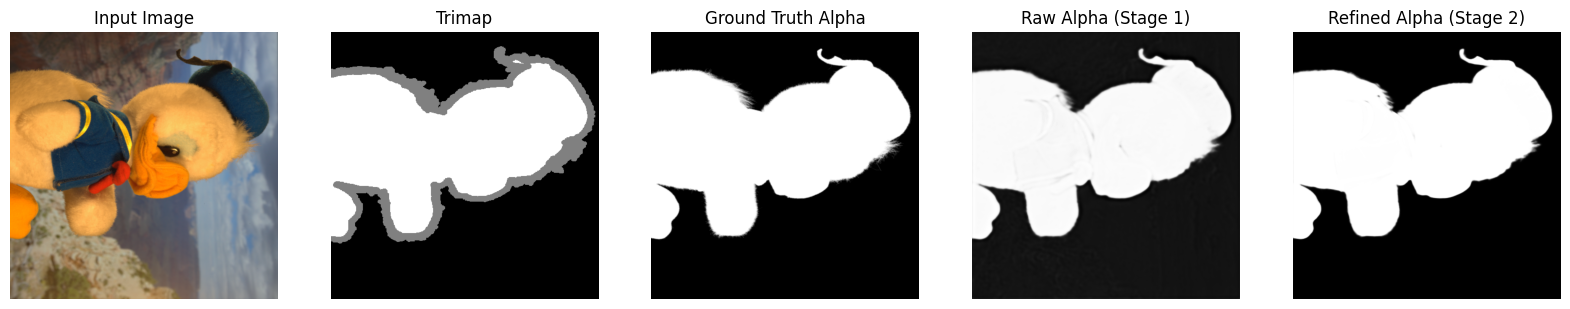

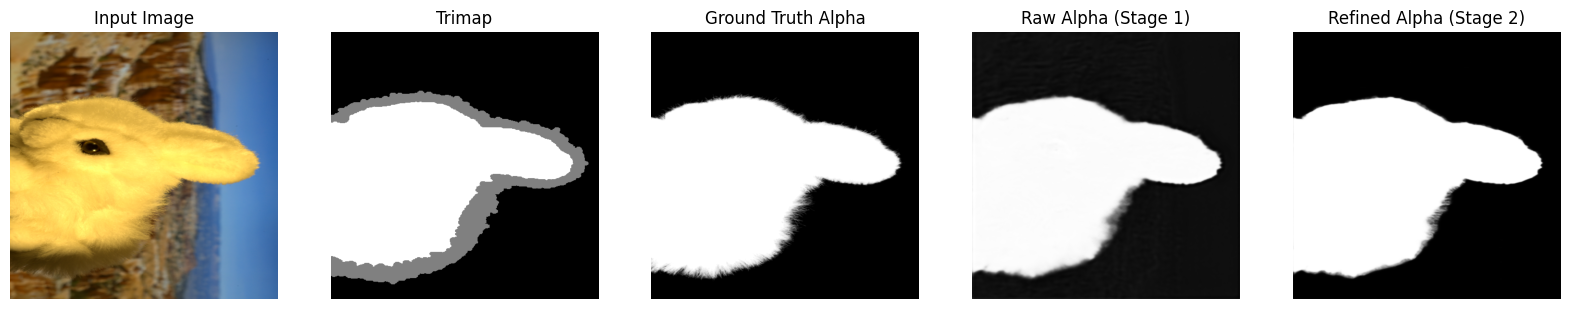

In [24]:
# Example usage
# Replace `model`, `dataset`, and `device` with your actual objects
visualize_results(model, data_loader, device, num_samples=3)